In [41]:
# 本节将介绍如何只利用Tensor和autograd来实现一个线性回归的训练。
# 首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
from d2lzh_pytorch import *

In [42]:
# 3.2.1 生成数据集
# 我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别
# 设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征X∈R1000×2，
# 我们使用线性回归模型真实权重w=[2,−3.4]⊤和偏差b=4.2，以及一个随机噪声项ϵ来生成标签
# y=Xw+b+ϵ，其中噪声项ϵ服从均值为0和标准差为0.01的正态分布
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]  # 线性回归模型真实权重
true_b = 4.2  # 线性回归模型真实偏差
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 为了使得标签不完全等于基于特征的真实的标签，我们添加一个均值为0，标准差为0.01的正态分布噪声项
# np.random.normal(loc=0.0, scale=1.0, size=None)用于生成一个指定均值、标准差的正态分布
# loc = 0.0: 正态分布的均值，这里设置为0
# scale = 1.0: 正态分布的标准差，这里设置为0.01
# size = None: 生成的随机数的形状，这里设置为labels.size()，即生成与labels形状相同的随机数

# torch.tensor(data, dtype=None, device=None, requires_grad=False)用于将数据转换成Pytorch张量
# data：输入数据，这里是Numpy数组
# dtype = torch.float32: 指定张量数据类型为32位浮点数
# 其它参数使用默认值
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)
# 注意，features的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量（标量）

C:\Users\Susan_Jay\AppData\Local\Temp\ipykernel_23896\1833178855.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


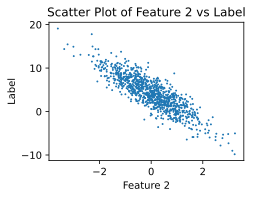

In [43]:
# 通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
# 从张量 features 中提取第二个特征（即第 1 列，索引从 0 开始）
# .numpy()将张量转换为numpy数组, Matplotlib的绘图函数(如plt.scatter)接受Numpy数组作为输入，而不是Pytorch张量
# 将标签张量 labels 转换为 NumPy 数组。labels 是一个形状为 (1000, 1) 的一维张量，表示每个样本的标签
# plt.scatter(x, y, s=None, …):散点图绘制函数，用于绘制点的分布
# x：点的横坐标，这里是第二个特征features[:, 1]的值
# y：点的纵坐标，这里是标签labels的值
# s：点的大小，这里设置为1, 表示点的大小非常小
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.xlabel('Feature 2')
plt.ylabel('Label')
plt.title('Scatter Plot of Feature 2 vs Label')
plt.show()

In [44]:
# 3.2.2 读取数据
# 在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。
# 这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [45]:
# 让我们读取第一个小批量数据样本并打印:每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.5760,  2.0938],
        [-0.5936,  0.9566],
        [ 0.7851, -0.3018],
        [-0.4405, -0.0901],
        [ 0.3223,  0.0249],
        [-0.0245,  0.7585],
        [ 0.9141,  0.7471],
        [ 0.1655, -1.3304],
        [-0.4077,  0.1716],
        [ 0.5698, -0.0709]]) tensor([-4.0759, -0.2461,  6.7840,  3.6366,  4.7471,  1.5788,  3.4790,  9.0647,
         2.8133,  5.5741])


In [46]:
# 3.2.3 初始化模型参数
# 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0
# 此处的num_inputs表示输入特征的数量（上文已定义），作用：
# 生成一个形状为 (2, 1) 的二维数组，其中的每个元素是从均值为 0、标准差为 0.01 的正态分布中随机采样得到的
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [47]:
# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的requires_grad=True
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [48]:
# 3.2.4 定义模型
# 下面是线性回归的矢量计算表达式的实现——我们使用mm函数做矩阵乘法
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

In [49]:
# 3.2.5 定义损失函数
# 我们使用上一节描述的平方损失来定义线性回归的损失函数。
# 在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [50]:
# 3.2.6 定义优化算法
# 以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。
# 这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:  # params 是一个包含所有模型参数的可迭代对象（例如列表或字典），是需要被优化的参数
        # 注意这里更改param时用的param.data，这是 param 的数据部分，表示参数的实际值
        # 使用 param.data 可以直接修改参数的值，而不会影响 PyTorch 的计算图
        # 作用：在优化过程中，直接更新参数的值，而不影响梯度的计算
        param.data -= lr * param.grad / batch_size   # param.grad 是 param 的梯度，表示损失函数对该参数的偏导数

In [51]:
# 3.2.7 训练模型
# 在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），
# 通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。
# 由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。
# 由于变量l并不是一个标量，运行l.backward()将对l中元素求和得到新的变量，再求该变量有关模型参数的梯度
# 注意在每次更新完参数后不要忘了将参数的梯度清零

lr = 0.03  # 学习率(learning rate), 通常是一个较小的正数，这里设置为0.03，决定了模型参数在每次迭代中更新的幅度
num_epochs = 3  # 迭代周期
net = linreg  # linreg是[100]中mm函数
loss = squared_loss  # squared_loss是[101]中的平方损失函数

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))
# 训练完成后，我们可以比较学到的参数和真实的模型参数

# 补充：data_iter 函数的设计使得在一个迭代周期（epoch）中，所有样本都会被分批次取出并使用一次。
# 虽然 for X, y in data_iter(batch_size, features, labels) 每次只取出一个小批量（例如 10 个样本），
# 但在整个 epoch 中，data_iter 会将数据集中的所有样本分成若干个小批量，逐一取出，直到所有样本都被使用

epoch 1, loss 0.036547
epoch 2, loss 0.000125
epoch 3, loss 0.000051


In [52]:
# 训练完成后，我们可以比较学到的参数和真实的模型参数
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0002],
        [-3.3997]], requires_grad=True)
4.2 
 tensor([4.1998], requires_grad=True)


In [53]:
# 3.2.8 小结
# 可以看出，仅使用Tensor和autograd模块就可以很容易地实现一个模型。
# 接下来，本书会在此基础上描述更多深度学习模型，并介绍怎样使用更简洁的代码（见下一节）来实现它们